This notebook provide all the walktrough to load data, transform it and then train a UNet (or any other model) on it.

In [1]:
#import libraries

import re
import cv2
import matplotlib.pyplot as plt
import os
import matplotlib.colors as mcolors
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from UNet_class_and_functions import* #this is not a library, but the python code storing UNet class and other useful functions

In [2]:
#Loading data an prepare it for training
from torchvision import transforms
t1 = RandomZoomAndShift()
t2 = RandomDownQuality()
# Define the transformation
transform_input = transforms.Compose([
    t1,
    t2,
    transforms.ToTensor()
])

transform_annotation = transforms.Compose([
    transforms.ToTensor()
])

#annotation_image_directory = "/home/gabriel/Documents/TR DIMA/data/UMons_train_images"
new_dataset_directory = "/home/gabriel/Documents/TR DIMA/data/UMons_preprocessed_images_v2"
new_annotations_directory = "/home/gabriel/Documents/TR DIMA/data/UMons_preprocessed_images_annotations_v2"

image_name_list = list_directory_contents(new_dataset_directory)

images_input = [] #3 channels images. the dataset is not so big, so we can stack it on a list, event if it's flash memory consuming
images_output = [] #2 channel image

for index,name in enumerate(image_name_list):        

        match = re.search(r'_(\d+)\.png', name) # Regular expression to extract the number

        number = int(match.group(1))

        image = cv2.imread(new_dataset_directory+'/'+f'UMons_preprocessed_image_v2_{number}.png')   
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        x,y,_ = image_rgb.shape
        image_rgb = transform_input(image_rgb)
        images_input.append(image_rgb)

        zoom_factor = t1.shift_h_range
        pos_factor = t1.shift_v_range
        new_width, new_height = int(x * zoom_factor), int(y * zoom_factor)
        raw_annotation = np.load(new_annotations_directory+'/'+ f'UMons_preprocessed_data_annotations_v2_{number}.npy')
        raw_annotation = raw_annotation*zoom_factor #zooming annotations

        raw_annotation[:,0] -= pos_factor[1] -(y-new_height)/2 #shifting annotations
        raw_annotation[:,1] -= pos_factor[0] - (x-new_width)/2
        raw_annotation = raw_annotation[:,::-1] #reversing

        relief_functions_test = dict(zip([i for i in range(len(raw_annotation))],[np.power]*len(raw_annotation)))

        parameters_test = { i : [2] for i in range(len(raw_annotation))}

        radius = [60*np.sqrt(2) for i in range(18)]

        raw_annotation = np.array(raw_annotation,dtype = np.int16) #converting to integer coordinates

        image_annotation = creation_relief_ulti_v2(raw_annotation,radius,relief_functions_test,parameters_test)

        image_annotation = transform_annotation(image_annotation)

        images_output.append(image_annotation)

In [3]:
random_seed = RANDOM_SEED #this variable is global to keep the same separation for all tests. We can thus avoid data leakage
print(random_seed)

train_set_index, test_set_index = train_test_split(np.array([i for i in range(len(images_input))]), test_size=0.2, random_state=58)
val_set_index, test_set_index = train_test_split(test_set_index, test_size=0.5, random_state=random_seed)

58


In [4]:
train_set = np.array(images_input)[train_set_index]
train_outputs = np.array(images_output)[train_set_index]

val_set = np.array(images_input)[val_set_index]
val_outputs = np.array(images_output)[val_set_index]

test_set = np.array(images_input)[test_set_index]
test_outputs = np.array(images_output)[test_set_index]

In [5]:
#create a new model with random weights
current_model = UNet(in_channels=3, out_channels = 1)
model_load = current_model

In [ ]:
#Or load an existing model to retrain

model_load = torch.load('model_to_retrain.pth',weights_only = False)

In [6]:
#creating test and train dataset and dataloader
batch_size = 8

# Convert to tensors
train_set = torch.Tensor(train_set)
train_outputs = torch.Tensor(train_outputs)
val_set = torch.Tensor(val_set)
val_outputs = torch.Tensor(val_outputs)
test_set = torch.Tensor(test_set)
test_outputs = torch.Tensor(test_outputs)



# Create a TensorDataset
train_dataset = TensorDataset(train_set, train_outputs)
val_dataset = TensorDataset(val_set, val_outputs)
test_dataset = TensorDataset(test_set, test_outputs)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example of iterating through the DataLoader
for images, labels in train_loader:
    print(images.shape, labels.shape)

torch.Size([8, 3, 256, 512]) torch.Size([8, 1, 256, 512])
torch.Size([8, 3, 256, 512]) torch.Size([8, 1, 256, 512])
torch.Size([8, 3, 256, 512]) torch.Size([8, 1, 256, 512])
torch.Size([8, 3, 256, 512]) torch.Size([8, 1, 256, 512])
torch.Size([8, 3, 256, 512]) torch.Size([8, 1, 256, 512])
torch.Size([8, 3, 256, 512]) torch.Size([8, 1, 256, 512])
torch.Size([8, 3, 256, 512]) torch.Size([8, 1, 256, 512])
torch.Size([8, 3, 256, 512]) torch.Size([8, 1, 256, 512])
torch.Size([8, 3, 256, 512]) torch.Size([8, 1, 256, 512])
torch.Size([8, 3, 256, 512]) torch.Size([8, 1, 256, 512])
torch.Size([8, 3, 256, 512]) torch.Size([8, 1, 256, 512])
torch.Size([8, 3, 256, 512]) torch.Size([8, 1, 256, 512])
torch.Size([8, 3, 256, 512]) torch.Size([8, 1, 256, 512])
torch.Size([8, 3, 256, 512]) torch.Size([8, 1, 256, 512])
torch.Size([8, 3, 256, 512]) torch.Size([8, 1, 256, 512])
torch.Size([8, 3, 256, 512]) torch.Size([8, 1, 256, 512])
torch.Size([8, 3, 256, 512]) torch.Size([8, 1, 256, 512])
torch.Size([8,

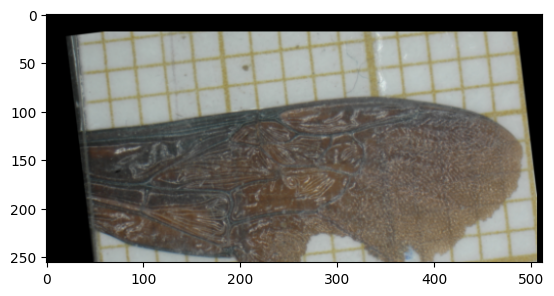

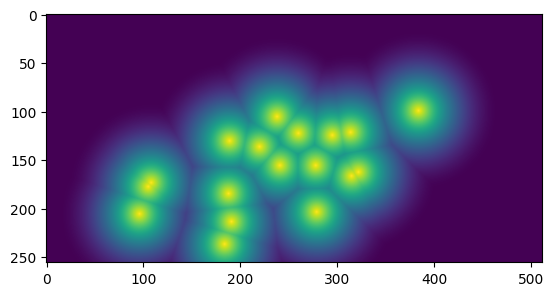

In [7]:
#checking integrity of data
for image,label in train_loader:
    plt.imshow(np.array(image)[0].transpose(1,2,0))
    plt.show()
    plt.imshow(np.array(label)[0].transpose(1,2,0))
    plt.show()
    break

In [8]:
#moving model to cuda (if you don't have cuda, this step has to be removed)
model_load.to('cuda')

# Define the loss function
criterion = nn.L1Loss()

# Define the optimizer
optimizer = optim.Adam(model_load.parameters(), lr=0.001)

In [9]:
# Assuming train_loader is your DataLoader for training data
num_epochs = 150  # Number of epochs to train
patience = 20 #patience
best_avg_val_loss = 1 #initialise validation loss
train_loss = []
val_loss = []

for epoch in range(num_epochs):
    model_load.train()  # Set the model to training mode
    running_train_loss = 0.0

    for images, labels in train_loader:
        # Move data to the appropriate device (GPU or CPU)
        images, labels = images.to('cuda'), labels.to('cuda')

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_load(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_train_loss += loss.item()


    # Compute average training loss
    avg_train_loss = running_train_loss / len(train_loader)

    # Compute test loss
    model_load.eval()  # Set the model to evaluation mode
    running_test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model_load(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

    # Compute average test loss and accuracy
    avg_test_loss = running_test_loss / len(val_loader)

    if best_avg_val_loss < avg_test_loss:
        patience_count +=1
    else : 
        patience_count = 0
        best_avg_val_loss = avg_test_loss
        model_best = model_load
    
    if patience_count >= patience:
        print("no more amelioration, stopping training")
        break
    

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_test_loss:.4f}')
    train_loss.append(avg_train_loss)
    val_loss.append(avg_test_loss)

Epoch [1/150], Train Loss: 0.1799, Validation Loss: 0.0954
Epoch [2/150], Train Loss: 0.0438, Validation Loss: 0.0608
Epoch [3/150], Train Loss: 0.0257, Validation Loss: 0.0228
Epoch [4/150], Train Loss: 0.0184, Validation Loss: 0.0210
Epoch [5/150], Train Loss: 0.0152, Validation Loss: 0.0148
Epoch [6/150], Train Loss: 0.0134, Validation Loss: 0.0169
Epoch [7/150], Train Loss: 0.0139, Validation Loss: 0.0148
Epoch [8/150], Train Loss: 0.0108, Validation Loss: 0.0117
Epoch [9/150], Train Loss: 0.0096, Validation Loss: 0.0102
Epoch [10/150], Train Loss: 0.0091, Validation Loss: 0.0132
Epoch [11/150], Train Loss: 0.0090, Validation Loss: 0.0120
Epoch [12/150], Train Loss: 0.0087, Validation Loss: 0.0096
Epoch [13/150], Train Loss: 0.0079, Validation Loss: 0.0101
Epoch [14/150], Train Loss: 0.0075, Validation Loss: 0.0089
Epoch [15/150], Train Loss: 0.0080, Validation Loss: 0.0106
Epoch [16/150], Train Loss: 0.0075, Validation Loss: 0.0105
Epoch [17/150], Train Loss: 0.0092, Validation Lo

In [10]:
#defining directories and names for saving

train_curve_directory = "/home/gabriel/Documents/TR DIMA/data_clean/train_curves/train"
val_curve_directory = "/home/gabriel/Documents/TR DIMA/data_clean/train_curves/val"
plot_directory = "/home/gabriel/Documents/TR DIMA/data_clean/train_curves/plot"
model_directory = "/home/gabriel/Documents/TR DIMA/data_clean/models"
model_name = "UNet_150_epoch_lr=0.001_seed=58_func=pow_param=2"

In [11]:
#saving train and validation curves

np.save(train_curve_directory + '/'+ "training_curve"+"_"+ model_name+".npy",np.array(train_loss))
np.save(val_curve_directory + '/'+ "val_curve"+"_"+ model_name+".npy",np.array(val_loss))

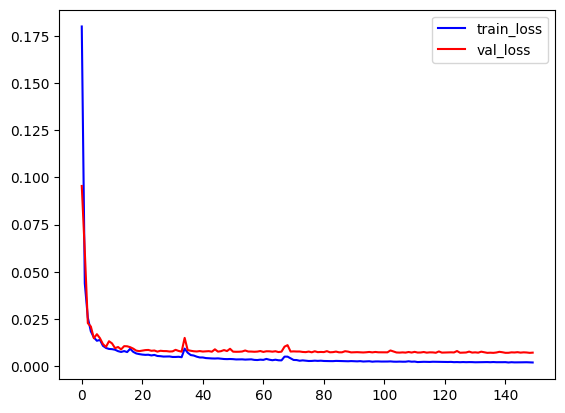

In [12]:
#plot the train and validation curves

plt.plot(train_loss,'b')
plt.plot(val_loss,'r')
plt.legend(["train_loss","val_loss"])
plt.show()

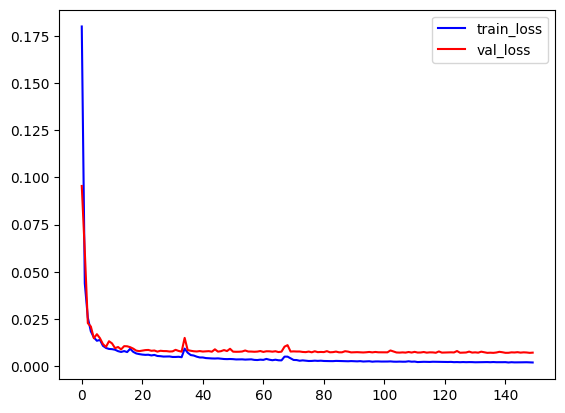

In [13]:
#saving the figure
plt.plot(train_loss,'b')
plt.plot(val_loss,'r')
plt.legend(["train_loss","val_loss"])
plt.savefig(plot_directory +"/" + 'plot_train_curve_' + model_name + ".png")

In [14]:
#saving the model 

torch.save(model_best,model_directory + '/' +model_name + ".pth")